# Load SageMaker SSD trained model for local inference or on-prime


### Clone mxnet source code
Ref: https://stackoverflow.com/questions/52889337/mxnet-sagemaker-load-model

1. clone mxnet source code
2. cp model_algo_1-xxxxx both json and para to model folder, incubator-mxnet/example/ssd/model/
3. deploy sm model to mxnet format
4. load model and inference


* Notes: for the GluonCV, ref [here](https://medium.com/@julsimon/quick-tip-converting-gluon-models-to-symbolic-format-9513e5dd1d73)

In [1]:
%%bash
git clone https://github.com/apache/incubator-mxnet

Cloning into 'incubator-mxnet'...


In [2]:
import boto3
sm = boto3.client('sagemaker')
response = sm.describe_training_job(TrainingJobName='object-detection-2020-04-22-09-25-36-709')
model_path = response['ModelArtifacts']['S3ModelArtifacts']
model_path

's3://beyoung-sagemaker/coco-object-detection-20200422/output/object-detection-2020-04-22-09-25-36-709/output/model.tar.gz'

In [3]:
!aws s3 cp {model_path} ./model.tar.gz

download: s3://beyoung-sagemaker/coco-object-detection-20200422/output/object-detection-2020-04-22-09-25-36-709/output/model.tar.gz to ./model.tar.gz


In [4]:
## cp model_algo_1-xxxxx both json and para to model folder, incubator-mxnet/example/ssd/model/
!tar -xvf ./model.tar.gz -C ./incubator-mxnet/example/ssd/model/

hyperparams.json
model_algo_1-0000.params
model_algo_1-symbol.json


In [5]:
!ls ./incubator-mxnet/example/ssd/model/

hyperparams.json  model_algo_1-0000.params  model_algo_1-symbol.json  README.md


# Load Model as checkpoint file and predict

In [6]:
!cp ./dog.jpg ./incubator-mxnet/example/ssd/data/demo/dog.jpg

In [7]:
# change notebook working directory
%cd ./incubator-mxnet/example/ssd

/home/ec2-user/SageMaker/myAWSStudyBlog/sagemaker-image-classification-detection/1-load-sm-model/incubator-mxnet/example/ssd


In [8]:
#deploy model as checkpoint format
!python deploy.py --network resnet50 --prefix model/model_algo_1 --num-class 80 --data-shape 512

[13:19:14] src/nnvm/legacy_json_util.cc:209: Loading symbol saved by previous version v1.4.1. Attempting to upgrade...
[13:19:14] src/nnvm/legacy_json_util.cc:217: Symbol successfully upgraded!
Saved model: model/deploy_model_algo_1-0000.params
Saved symbol: model/deploy_model_algo_1-symbol.json


In [9]:
# load model and predicate
import mxnet as mx
import numpy as np
import cv2
from collections import namedtuple

In [10]:
# define test data
batch_size = 1
num_batch = 1
filepath = './data/demo/dog.jpg'
DEFAULT_INPUT_SHAPE = 512

In [11]:
# load model
sym, arg_params, aux_params = mx.model.load_checkpoint("model/deploy_model_algo_1", 0)
mod = mx.mod.Module(symbol=sym, context=mx.cpu(), data_names=["data"], label_names=[])
print('data_names:', mod.data_names)
print('output_names:', mod.output_names)

data_names: ['data']
output_names: ['detection_output']


In [12]:
mod.bind(data_shapes=[("data", (1, 3, DEFAULT_INPUT_SHAPE, DEFAULT_INPUT_SHAPE))], for_training=False,label_shapes=mod._label_shapes)
mod.set_params(arg_params, aux_params)  # , allow_missing=True

In [13]:
img = cv2.cvtColor(cv2.imread(filepath), cv2.COLOR_BGR2RGB)
print(img.shape)
img = cv2.resize(img, (DEFAULT_INPUT_SHAPE, DEFAULT_INPUT_SHAPE))
img = np.swapaxes(img, 0, 2)
img = np.swapaxes(img, 1, 2)
img = img[np.newaxis, :]
print(img.shape)

(1362, 2048, 3)
(1, 3, 512, 512)


In [14]:
# forward
Batch = namedtuple('Batch', ['data'])
mod.forward(Batch([mx.nd.array(img)]))
prob = mod.get_outputs()[0].asnumpy()

In [15]:
prob.shape

(1, 6132, 6)

In [16]:
prob = np.squeeze(prob)
print(prob.shape)
# Grab result, convert to python list of lists and return
results = [prob[i].tolist() for i in range(10)]
print(results)

(6132, 6)
[[0.0, 0.5216841697692871, 0.7248552441596985, 0.0, 0.9101921916007996, 0.5743014812469482], [-1.0, 0.41219717264175415, 0.7113396525382996, 0.0, 0.9058343768119812, 0.5425474643707275], [0.0, 0.40109360218048096, 0.35489270091056824, 0.010450959205627441, 0.46446946263313293, 0.5140073299407959], [-1.0, 0.3892449140548706, 0.3271200656890869, 0.01007080078125, 0.5042054057121277, 0.6293030977249146], [-1.0, 0.38807913661003113, 0.7220096588134766, 0.02422201633453369, 0.9272550344467163, 0.5419011116027832], [16.0, 0.3286588490009308, 0.12686970829963684, 0.44898146390914917, 0.3471781611442566, 0.7077935338020325], [0.0, 0.3273720443248749, 0.3125830888748169, 0.03207471966743469, 0.5081927180290222, 0.6150685548782349], [-1.0, 0.3227827847003937, 0.3491026759147644, 0.012638121843338013, 0.45894384384155273, 0.5439571142196655], [-1.0, 0.313625305891037, 0.35684552788734436, 0.025891557335853577, 0.46641936898231506, 0.474692702293396], [0.0, 0.3079402446746826, 0.77736800

In [17]:
## need to remove class -1
klass, score, x0, y0, x1, y1 = -1.0, 0.41219717264175415, 0.7113396525382996, 0.0, 0.9058343768119812, 0.5425474643707275
print(klass < 0)

True


In [18]:
def visualize_detection(img_file, dets, classes=[], thresh=0.6):
        """
        visualize detections in one image
        Parameters:
        ----------
        img : numpy.array
            image, in bgr format
        dets : numpy.array
            ssd detections, numpy.array([[id, score, x1, y1, x2, y2]...])
            each row is one object
        classes : tuple or list of str
            class names
        thresh : float
            score threshold
        """
        import random
        import matplotlib.pyplot as plt
        import matplotlib.image as mpimg

        img=mpimg.imread(img_file)
        plt.imshow(img)
        height = img.shape[0]
        width = img.shape[1]
        colors = dict()
        for det in dets:
            (klass, score, x0, y0, x1, y1) = det
            ## need to remove class -1
            if klass < 0 or score < thresh:
                continue
            cls_id = int(klass)
            if cls_id not in colors:
                colors[cls_id] = (random.random(), random.random(), random.random())
            xmin = int(x0 * width)
            ymin = int(y0 * height)
            xmax = int(x1 * width)
            ymax = int(y1 * height)
            rect = plt.Rectangle((xmin, ymin), xmax - xmin,
                                 ymax - ymin, fill=False,
                                 edgecolor=colors[cls_id],
                                 linewidth=1)
            plt.gca().add_patch(rect)
            class_name = str(cls_id)
            if classes and len(classes) > cls_id:
                class_name = classes[cls_id]
            plt.gca().text(xmin, ymin - 2,
                            '{:s} {:.3f}'.format(class_name, score),
                            bbox=dict(facecolor=colors[cls_id], alpha=0.5),
                                    fontsize=12, color='white')
        plt.savefig('result.jpg', dpi=500)
        plt.show()

In [19]:
object_categories = ['person', 'bicycle', 'car',  'motorbike', 'aeroplane', 'bus', 'train', 'truck', 'boat', 
                     'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog',
                     'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag',
                     'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat',
                     'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
                     'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot',
                     'hot dog', 'pizza', 'donut', 'cake', 'chair', 'sofa', 'pottedplant', 'bed', 'diningtable',
                     'toilet', 'tvmonitor', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven',
                     'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier',
                     'toothbrush']

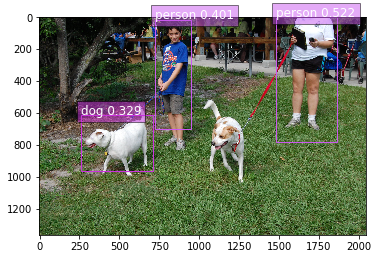

In [21]:
# Setting a threshold 0.20 will only plot detection results that have a confidence score greater than 0.20.
threshold = 0.328
# Visualize the detections.
visualize_detection(filepath, results, object_categories, threshold)